# Rossman Store Sales Analysis
This analysis is based on the Kaggle data challenge to forecast Rossman Store's sales using store, promotion, and competitor data. This projects consists of three parts:

#### Part A - Exploratory Data Analysis  
#### Part B - Time Series Analysis & Predictive Modelling 
#### Part C - Results & Conclusions


In [638]:
# Import required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os

# statistics
from math import sqrt
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [170]:
# Importing store data
store = pd.read_csv('./data/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [171]:
# Importing train data
train = pd.read_csv('./data/train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [176]:
# Importing test data
test = pd.read_csv('./data/test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


## Part A - Exploratory Data Analysis (EDA)

In [182]:
# Checking train data
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [183]:
train.shape

(1017209, 8)

Our training data has 1M+ observations of sales data over the year of approximately 2 years (2013-2015). This is a time series data i.e an ordered sequence of values of a variable (here Sales) at equally spaced time intervals (daily, weekly, monthly, yearly). Let's do some feature engineering to make it easier for analysis.

In [184]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [186]:
# Checking train data again
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [246]:
# Checking data when the stores were closed
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


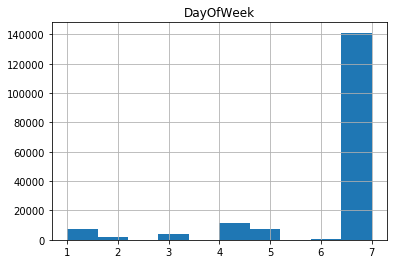

In [247]:
# Checking days when the stores were closed
train_store_closed.hist('DayOfWeek');

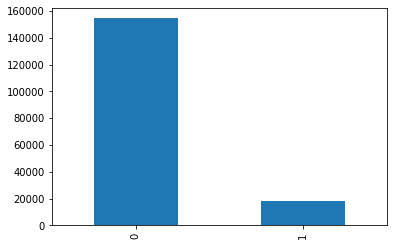

In [249]:
# Checking whether there was a school holiday when the store was closed
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

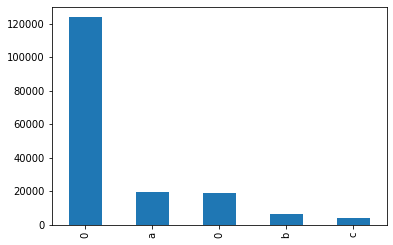

In [250]:
# Checking whether there was a state holiday when the store was closed
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

We can see from the above plot that stores were mostly closed on 7th day i.e Sunday and it makes sense. On other days, they were closed because of a school holiday or/and a state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None).


In [251]:
# Checking missing values in train set - no missing value
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [259]:
# No. of days with closed stores
train[(train.Open == 0)].shape[0]

172817

In [260]:
# No. of days when store was opened but zero sales - might be because of external factors or refurbishmnent
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [261]:
# Checking store data
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [262]:
# Checking missing values in store data 
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Only 3 observations have 'Competition Distance' missing. This is probably because someone didn't enter the information in the system. It's safe to replace these missing values with the median. We can't use the same approach with competition's existence (month and year) as it doesn't make sense. It is better to replace it with 0 (i.e launched recently). We'll also impute the missing values in promo with 0 as no information about promo is avaialable.

In [263]:
# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [264]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [266]:
# Checking test data
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [267]:
# Checking missing values
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [268]:
# Assuming stores open in test
test.fillna(1, inplace=True)

In [573]:
# Joining the tables
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,level_0,index,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,0,2015-07-31,1,5,5263.0,555,1,1,0,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1115,1115,2015-07-30,1,4,5020.0,546,1,1,0,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2230,2230,2015-07-29,1,3,4782.0,523,1,1,0,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,3345,3345,2015-07-28,1,2,5011.0,560,1,1,0,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,4460,4460,2015-07-27,1,1,6102.0,612,1,1,0,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [283]:
# Distribution of sales and customers across store types
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


From above table, we can see that Store of type 'a' and 'd' have the highest total sales but stores of type 'c' and 'b' have the highest sale per customer. 

### Correlation Analysis

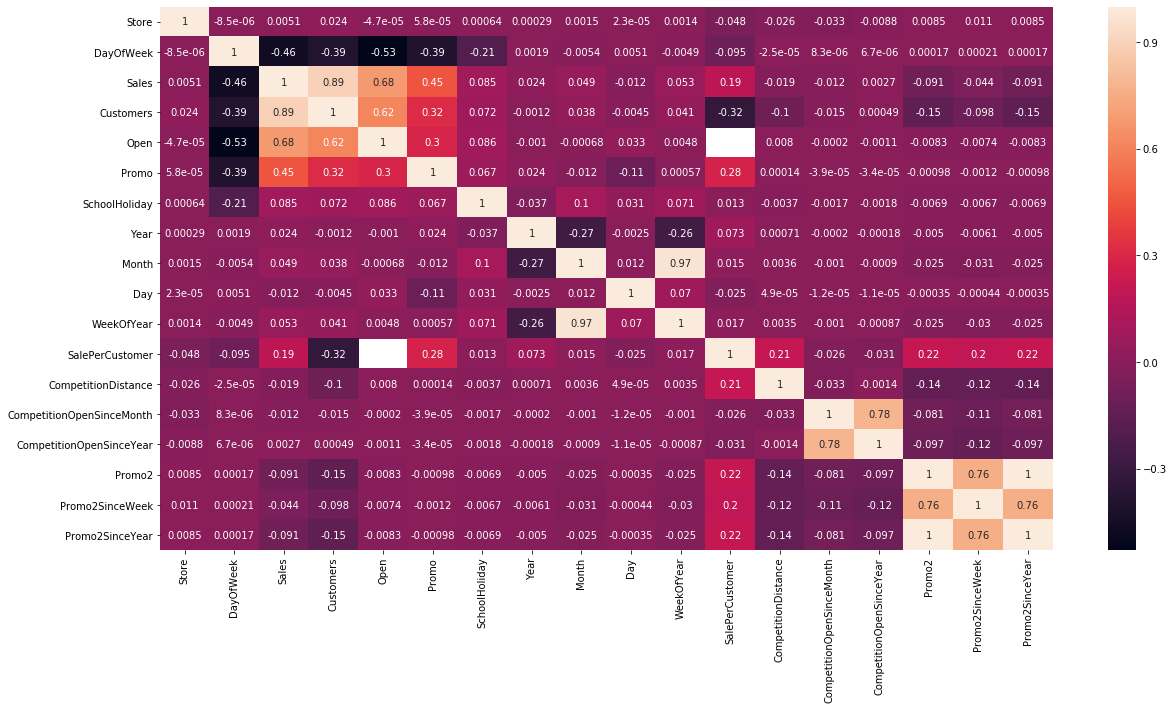

In [317]:
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True);

We can see a strong positive correlation between the amount of Sales and Customers visiting the store. We can also observe a positive correlation between a running promotion (Promo = 1) and number of customers.

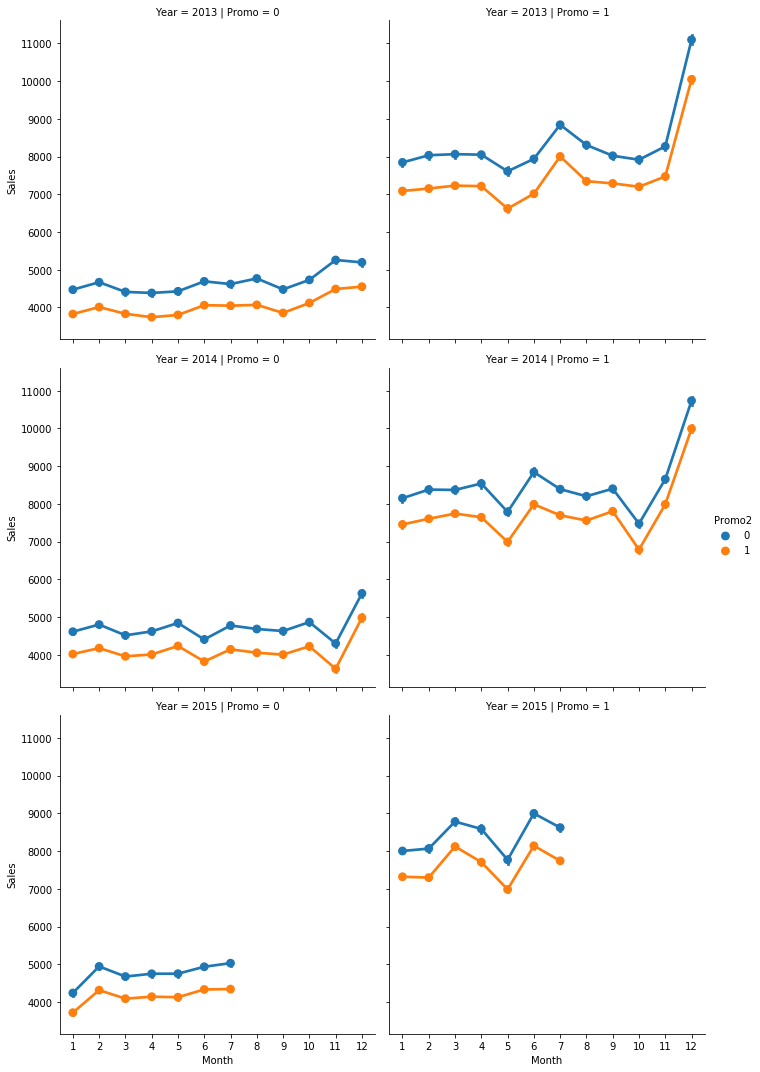

In [324]:
# Sales trend over the months
sns.factorplot(data = train_store_joined, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
             )

We can see from the above trends that sales tend to spike in November and December. So, there is a seasonality factor present in the data.

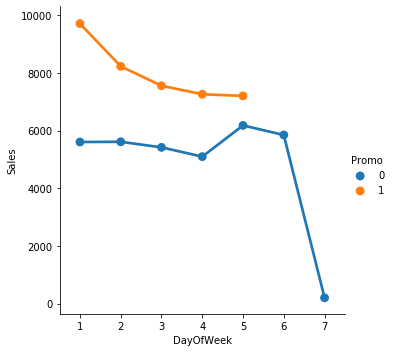

In [330]:
# Sales trend over days
sns.factorplot(data = train_store_joined, x = "DayOfWeek", y = "Sales", hue = "Promo")

We can see from the trend that there are no promotions on the weekends i.e Saturday and Sunday, which makes sense as stores want to earn a maximum profit during the time when people do their house chores. The sales tend to decline on Sunday, because a majority of stores are closed on Sundays. We can also see tha the maximum sale happens on Mondays when there are promotional offers.

### Conclusions of EDA

a) The most selling and crowded StoreType is A. <br>

b) StoreType B has the highest Sale per Customer.<br>

c) Customers tends to buy more on Mondays when there are ongoing promotional offers and on Thursdays/Fridays when there is no promotion at all. <br>

d) Second promotion (Promo2) doesn't seem to contribute in the increase of sales. 

## Part B - Time Series Analysis & Predictive Modelling 

### Time Series Analysis

For Time Series Anlaysis , we will consider one store from each store type a , b , c , d that will represent their respective group. It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [122]:
pd.plotting.register_matplotlib_converters()

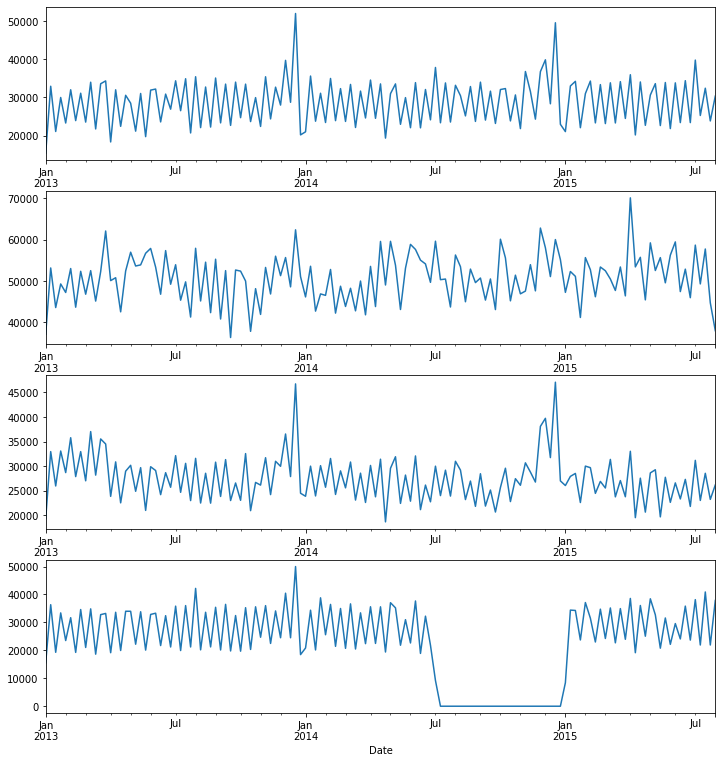

In [331]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

We can see from above plots that sales for StoreType A and C tend to peak in the end of year (Christmas season) and then decline after the holidays. We are not able to see a similar trend in StoreType D because no data is available for that time period (stores closed).


### Stationarity of Time Series 
In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean constant variance and constant covariance with time. 

There are 2 ways to test the stationarity of time series <br>
a) Rolling Mean: Visualization
b) Dicky - Fuller test: Statistical test

a) Rolling Mean: A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slided across the data) on weekly basis , in which the average is taken on weekly basis. Rolling Statistics is a visualization test , where we can compare the original data with the rolled data and check if the data is stationary or not. 

b) Dicky - Fuller test: This test prvoides us the stastical data such as p value to understand whether we can reject null hypothesis. Null hypothesis is that data is not stationary and alternative hypothesis says that data is stationary. If p value is less than the critical value (say 0.5), we will reject null hypothesis and say that data is stationary.

In [335]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

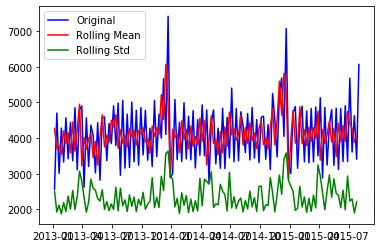

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [336]:
# Testing stationarity of store type a
test_stationarity(sales_a)

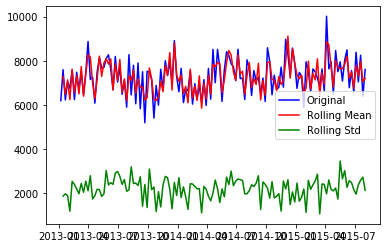

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [337]:
#Testing stationarity of store type b
test_stationarity(sales_b)

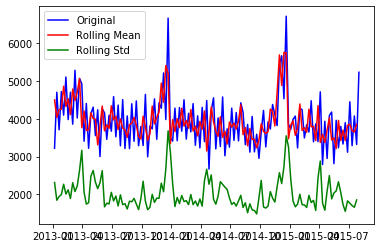

Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [338]:
#Testing stationarity of store type b
test_stationarity(sales_c)

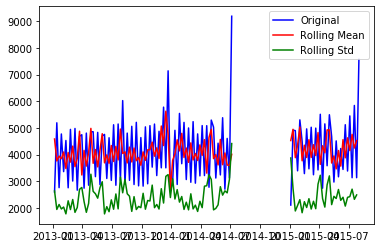

Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [339]:
#Testing stationarity of store type d
test_stationarity(sales_d)

We can see from the above plots and statistical tests that mean and variation doesn't change much with time, i.e they are constant. Thus, we don't need to perform any transformation (needed when time series is not stationary). 

Now, let's check the trend and seasonality in our data.

In [352]:
# Plotting seasonality and trend
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

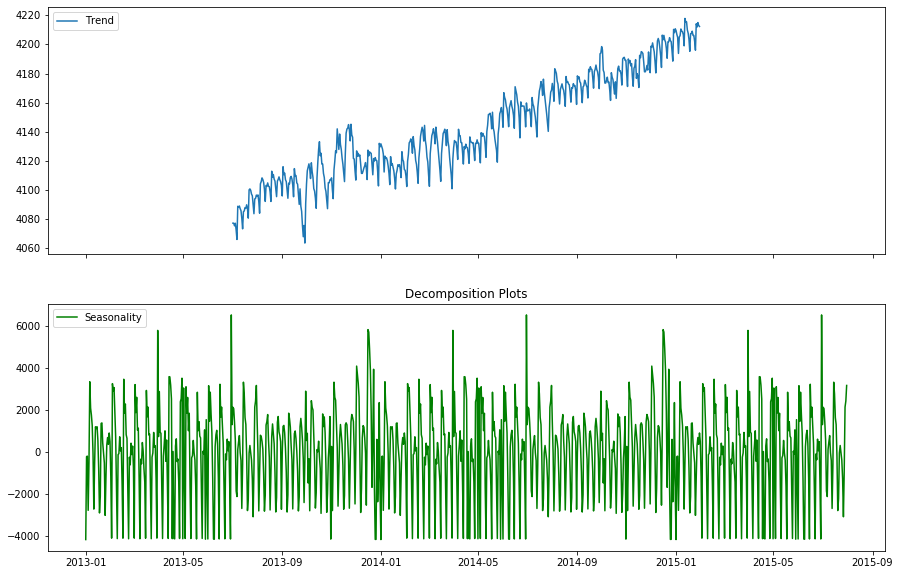

In [353]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

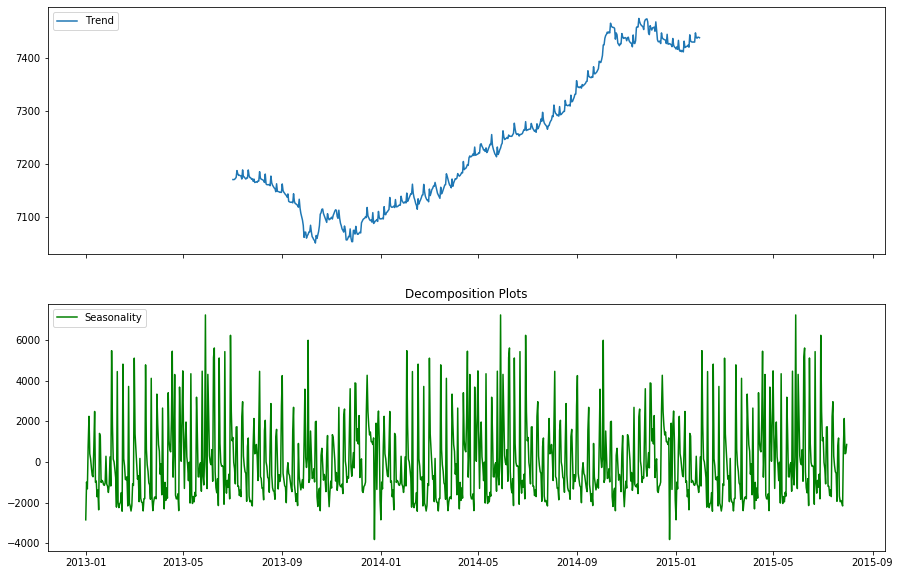

In [354]:
# Plotting seasonality and trend for store type b
plot_timeseries(sales_b,'b')

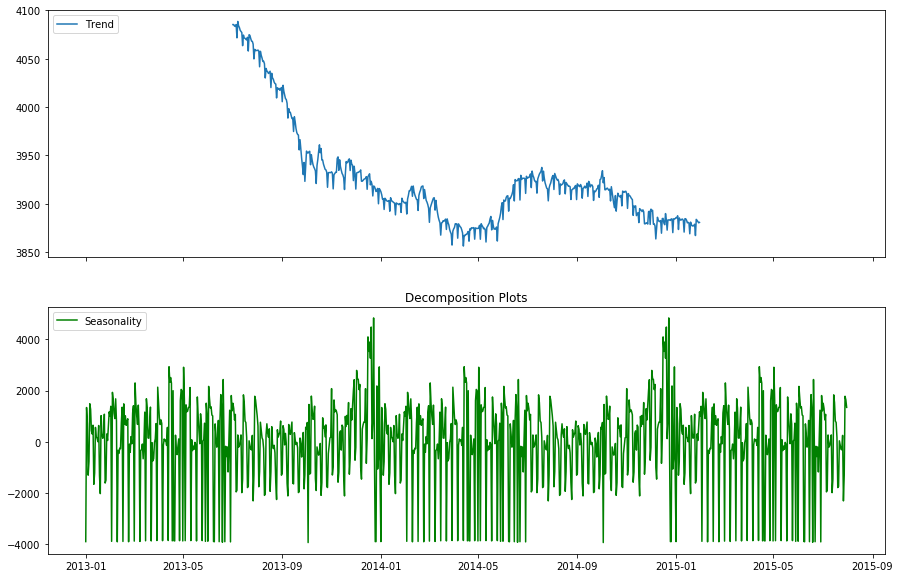

In [355]:
# Plotting seasonality and trend for store type c
plot_timeseries(sales_c,'c')

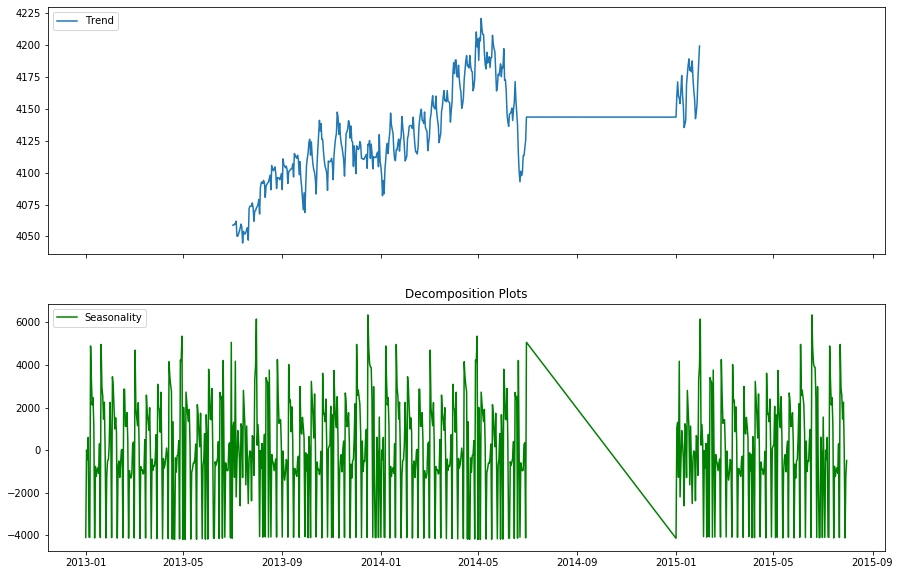

In [357]:
# Plotting seasonality and trend for store type d
plot_timeseries(sales_d,'d')

From the above plots, we can see that there is a seasonality and trend present in out data. So, we'll use forecasting models that take both of these factors into consideration. For example, SARIMAX and Prophet. 

## Forecasting a Time Series

### Model 1 - SARIMA (Seasonal Autoregressive Integrated Moving Average)
In order to use this model, we need to first find out values of p, d and q. 
p represents number of Autoregressive terms - lags of dependent variable.
q represents number of Moving Average terms - lagged forecast errors in prediction equation.
d represents number of non-seasonal differences.

To find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots. 

ACF - measure of correlation between time series with a lagged version of itself. 
PACF - measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

p value is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.
q value is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.

Now, let's plot these graphs.

In [360]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

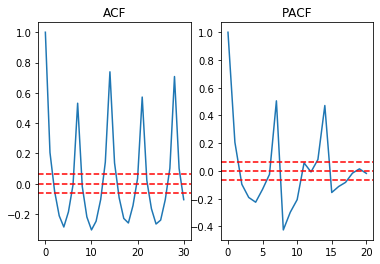

In [361]:
# ACF and PACF for store type a
auto_corr(sales_a)

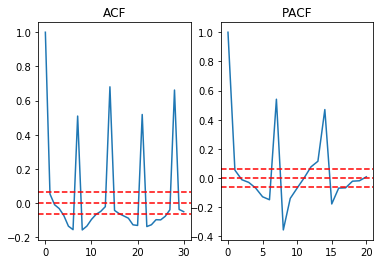

In [362]:
# ACF and PACF for store type b
auto_corr(sales_b)

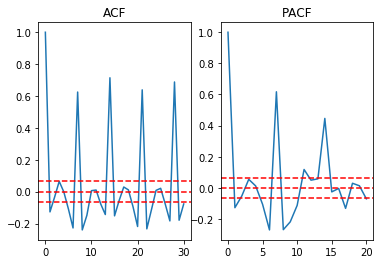

In [363]:
# ACF and PACF for store type c
auto_corr(sales_c)

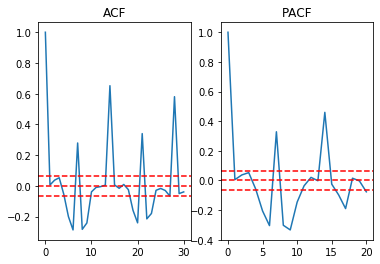

In [364]:
# ACF and PACF for store type d
auto_corr(sales_d)

The above graphs suggest that the p = 2 and q = 2 but let's do a grid search and see which combination of p, q and d gives the lowest Akaike information criterion (AIC, which tells us the quality of statistical models for a given set of data. Best model uses the lowest number of features to fit the data.

If we are to predict the sales of each store, we need to consider the whole data set rather than one store of each category. We took one store of each category to understand the tiem series data but from now on, we'll use the whole dataset for modelling.

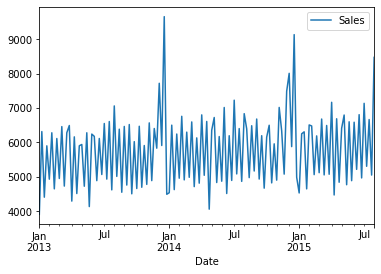

In [380]:
# Summing sales on per week basis
train_arima = train.resample("W").mean() 
train_arima = ts_arima[["Sales"]]
train_arima.plot();

In [381]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Now, let's iterate through these combinations to see which one gives the lowest AIC score.

In [382]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807691303
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522795486
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.7057912673176
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107341433
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.336694340892
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.886830504035
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.017189113568
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.635325967007
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.0426171360436
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.9085964383717
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089752304
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842539744
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.58045319303


In [385]:
# Fitting the data to SARIMA model - using optimal parameter: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.2981906705384
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323
ma.L1         -0.9559      0.050    -19.076      0.000      -1.054      -0.858
ma.S.L12      -1.0120      0.831     -1.218      0.223      -2.640       0.616
sigma2      8.268e+05   7.31e+05      1.131      0.258   -6.06e+05    2.26e+06


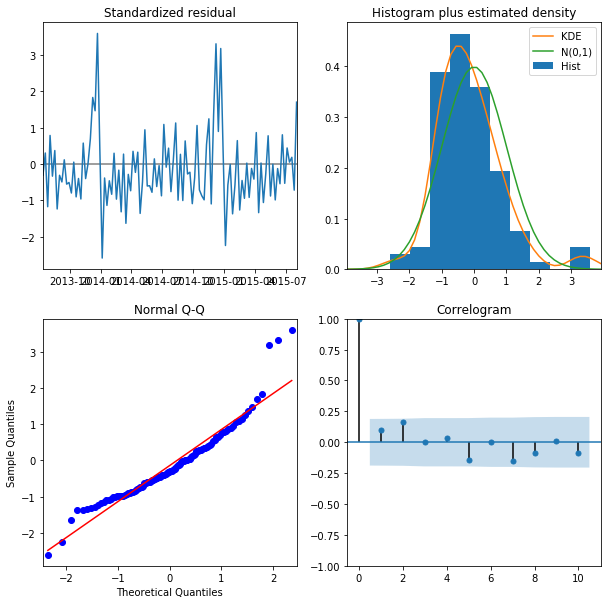

In [386]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

We can see from the above 'Histogram plus estimated density' plot that our KDE (Kernel Desnity Estimator) plot closely follows the N(0,1) normal distribution plot. The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

Standardized residual plot tells us that there is no major seasonality trend, which is confirmed by Correlogram (autocorrelation) plot. Autocorrelation plot tells us that the time series residuals have low correlation with lagged versions of itself.

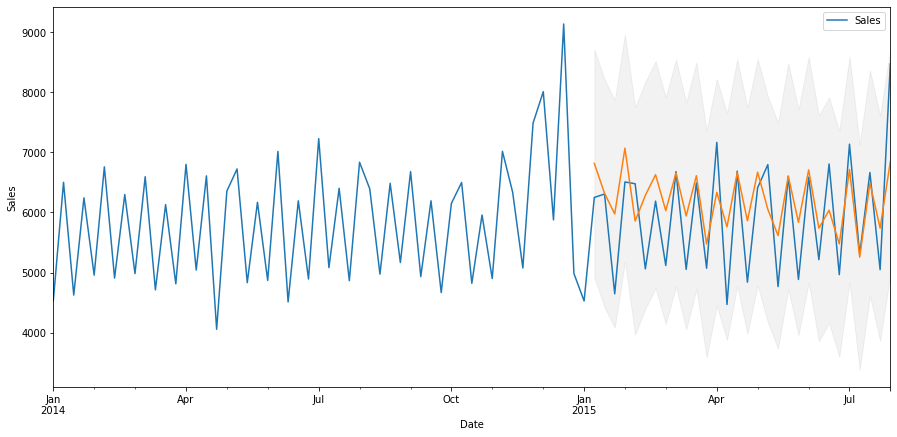

Root Mean Squared Error:  739.0611630836089


In [402]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

## Model 2 - Prophet

In [437]:
# Joining the train and stoore data
train_store_prophet = pd.merge(train, store, how='inner', on='Store')

,level_0,index,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,0,2015-07-31,1,5,5263.0,555,1,1,0,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1115,1115,2015-07-30,1,4,5020.0,546,1,1,0,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2230,2230,2015-07-29,1,3,4782.0,523,1,1,0,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,3345,3345,2015-07-28,1,2,5011.0,560,1,1,0,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,4460,4460,2015-07-27,1,1,6102.0,612,1,1,0,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [439]:
# Encoding state holiday categorical variable
train_store_prophet["StateHoliday_cat"] = train_store_prophet["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})

In [441]:
# Choosing only required cols
train_store_prophet = train_store_prophet[['Date', 'Sales', 'SchoolHoliday', 'StateHoliday_cat']]
train_store_prophet.head()

,Date,Sales,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263.0,1,0
1,2015-07-30,5020.0,1,0
2,2015-07-29,4782.0,1,0
3,2015-07-28,5011.0,1,0
4,2015-07-27,6102.0,1,0


In [443]:
# Converting col names to specific names as required by Prophet library
train_store_prophet = train_store_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
train_store_prophet.head()

,ds,y,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263.0,1,0
1,2015-07-30,5020.0,1,0
2,2015-07-29,4782.0,1,0
3,2015-07-28,5011.0,1,0
4,2015-07-27,6102.0,1,0


In [444]:
# Modelling holidays - creating holidays dataframe
state_dates = train_store_prophet[(train_store_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = train_store_prophet[(train_store_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday",  "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday", "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-05-25
2,state_holiday,2015-05-14
3,state_holiday,2015-05-01
4,state_holiday,2015-04-06


In [445]:
# Dropping holiday columns because not needed any more
train_prophet_clean = train_store_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1)
train_prophet_clean.head()

,ds,y
0,2015-07-31,5263.0
1,2015-07-30,5020.0
2,2015-07-29,4782.0
3,2015-07-28,5011.0
4,2015-07-27,6102.0


In [448]:
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = train_prophet_clean.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,y
ds,
2013-01-06,26129335.0
2013-01-13,49275222.0
2013-01-20,34377765.0
2013-01-27,46040169.0
2013-02-03,38466029.0


In [450]:
# Resetting the index
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,y
0,2013-01-06,26129335.0
1,2013-01-13,49275222.0
2,2013-01-20,34377765.0
3,2013-01-27,46040169.0
4,2013-02-03,38466029.0


In [451]:
# Fitting data to Prophet model
prophet = Prophet(holidays = holidays) 
prophet.fit(ts_week_prophet_train)
print("done")

future = prophet.make_future_dataframe(periods = 52, freq = "W") 
forecast = prophet.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


done


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.414438e+07,3.507466e+07,5.363260e+07
183,2016-07-10,4.383894e+07,3.485666e+07,5.367206e+07
184,2016-07-17,4.410799e+07,3.503024e+07,5.278212e+07
185,2016-07-24,4.412114e+07,3.517861e+07,5.329572e+07
186,2016-07-31,4.352276e+07,3.417156e+07,5.278125e+07


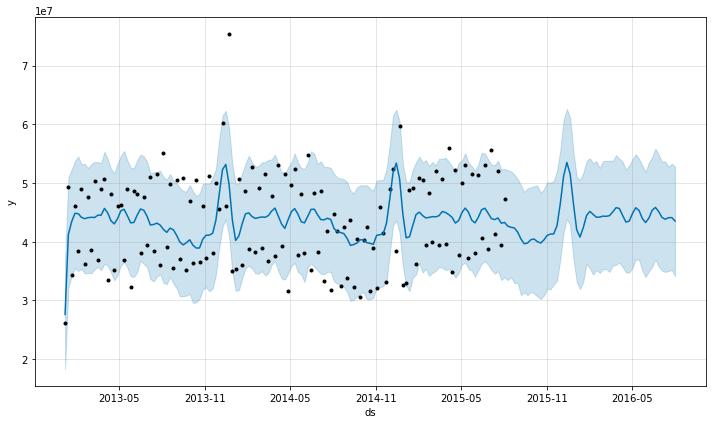

In [452]:
# Visualizing predicions of forecast
prophet.plot(forecast);

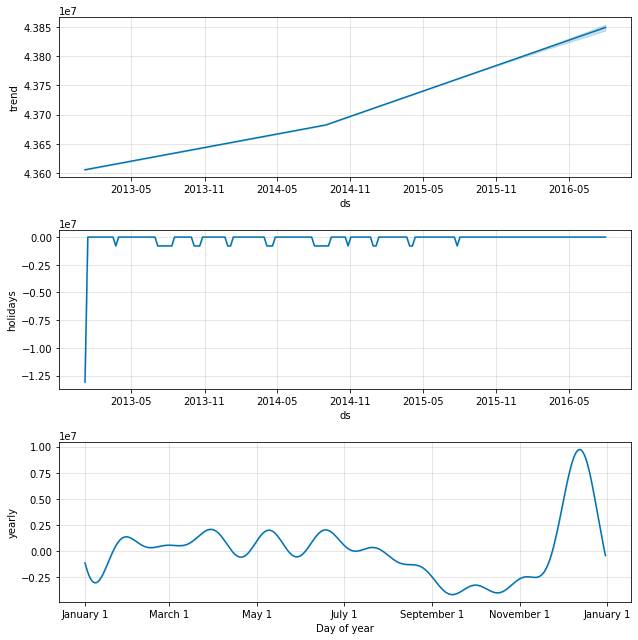

In [453]:
# Visualizing trend and seasonality components
prophet.plot_components(forecast);

The first plot shows that the total sales on weekly basis is increasing. The second plot shows the holdiay gaps in the dataset and the third plot shows that the store sees a very high sales in the last week of December (because of Christmas holidays).

In [666]:
# Checking the RMSE fo Prophet model
metric_prophet = forecast.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet.dropna(inplace=True)
rms_prophet = mean_squared_error(metric_prophet.y, metric_prophet.yhat)
rms_prophet

52478331938232.15

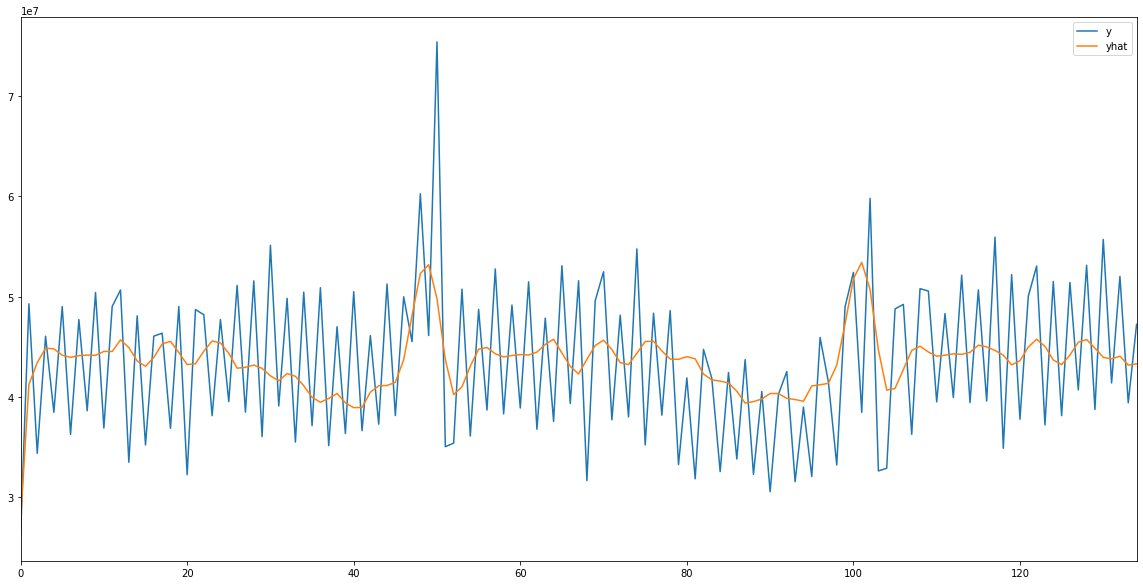

In [471]:
# Visualizing the performance of model
plt.figsize=(10,20)
metric_prophet["y"].plot(figsize=(20,10))
metric_prophet["yhat"].plot()
plt.legend()
plt.show()

From the above RMSE and plot, we can see that Prophet isn't performing that well as compared to SARIMA. Let's try another model.

## Model 3 - XGBoost
We'll need to convert all categorical variables into numerical/dummy variables in order to implement XGBoost. We'll also drop columns that are correlated (e.g Customers, Sale Per Customer) in addition to merging similar columns into one column (CompetitionOpenSinceMonth, CompetitionOpenSinceYear).

In [654]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)

In [655]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [656]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [657]:
# Splitting the data
features = ts_xgboost.drop(["level_0", "index", "Date", "Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20) 

In [658]:
# Tuning parameters
params = {'max_depth':10, "booster": "gbtree", 'eta':1, 'silent':1, 'objective':'reg:linear'}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[0]	train-rmse:2276.87	eval-rmse:2273.29
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:2181.67	eval-rmse:2189.39
[2]	train-rmse:1931.25	eval-rmse:1943.08
[3]	train-rmse:1760.33	eval-rmse:1780.23
[4]	train-rmse:1709.45	eval-rmse:1730.75
[5]	train-rmse:1661.13	eval-rmse:1683.72
[6]	train-rmse:1483.42	eval-rmse:1507.33
[7]	train-rmse:1351.57	eval-rmse:1383.85
[8]	train-rmse:1306.87	eval-rmse:1346.41
[9]	train-rmse:1247.12	eval-rmse:1286.91
[10]	train-rmse:1200.91	eval-rmse:1244.55
[11]	train-rmse:1164.7	eval-rmse:1210.98
[12]	train-rmse:1151.46	eval-rmse:1199.15
[13]	train-rmse:1122.26	eval-rmse:1174.84
[14]	train-rmse:1098.69	eval-rmse:1157.56
[15]	train-rmse:1069.7	eval-rmse:1130.36
[16]	train-rmse:1055.71	eval-rmse:1118.7
[17]	train-rmse:1020.16	eval-rmse:1087.15
[18]	train-rmse:1006.93	eval-rmse:1076.73
[19]	train-rmse:988.314	eval-rmse:1061.48
[20]	train-rmse:960.008	eval-

In [659]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 847.7588542910149


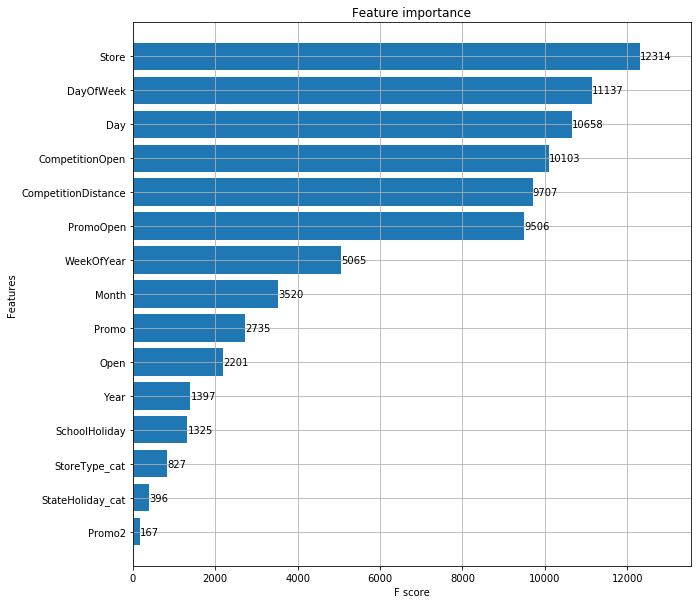

In [660]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Results

In [699]:
# Comparing performance of above three models - through RMSE
rms_arima = format(float(rms_arima))
rms_prophet = format(float(rms_prophet))
rms_xgboost = format(float(rms_xgboost))

model_errors = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "XGBoost"],
    "RMSE": [rms_arima, rms_prophet, rms_xgboost]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
1,Prophet,52478331938232.15
0,SARIMA,739.06116308
2,XGBoost,847.75885429


We used Root Mean Squared Error (RMSE) to evaluate and validate the performance of various models used. Let's see which model performed better and why/why not.

a) We can see from the above table that SARIMA performs the best followed by XGBoost and Prophet. 

b) It makes sense because SARIMA is designed specifically for seasonal time series data while XGBoost is a general (though powerful) machine learning appproach with various applications. 

c) Prophet is a good choice for producing quick forecasts as it doesn't require strong technical skills. It is easy to implment at scale. The reason for its poor performance here is probably because of a lack of data. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

### Conclusions

a) Our task was to predict the sales of each store for next month. We started by exploring the time series data and then did some feature engineering to prepare the data for modelling. Finally, we used various modelling techniques such as SARIMA, Prophet and XGBoost to predict the sales. SARIMA, a model designed specifically for time series performed the best. We also plotted the truth vs predicted sales to understand the performance of model in addition to calcualting squared mean error.

b) The most interesting thing about the project was that the category of stores having highest sales don't have the highest sale per customer. It might be because those stores sell small items, which are needed on daily basis.

c) Another interesting thing was that running a promotion for the second time doesn't help in increasing the sales. It is probably because customers already purchased whatever they wanted during the first promotional sale.

d) Improvement Area: 
i) We could have used the tranformation techniques to smoothen the data e.g using Moving Average, Log transformation etc. to remove seasonality and trend and make the time series more stationary. After building the model, we would have introduced the behavior of seasonality and trend back to the results. This might have resulted in a better model with a lower RMSE.

ii) We could also use SARIMAX model that take exogenous variables. These are the variables whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it. For example, Competition Open, Promo Open, etc.



